In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from scipy.signal import stft, istft, get_window
from scipy.fftpack import fft, fftshift, fftfreq
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook, tqdm
from dlbeamformer_utilities import *
from dlbeamformers import *
from utilities import *
from IPython.display import Audio

random_seed = 0
# Make pretty figures
palette, cmap = config_figures()

VISUALIZE_BEAMPATTERNS = False

In [2]:
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data, test_data = load_data(datapath)

sampling_frequency, stft_params, sound_speed = parse_parameters()

signal_max_frequency = sampling_frequency / 2

# Array geometry
pos_x = np.array([-35.0, -35.0, 0.0, 35.0, 35.0, 0.0, 0.0]) * 1e-3
pos_y = np.array([20.0, -20.0, -40.0, -20.0, 20.0, 40.0, 0.0]) * 1e-3
n_mics = len(pos_x)
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))

# Fix elevation angle
elevation = -90 # [degree]

# Source/Target/Look angles
elevation_s = np.array([elevation]) # [degree]
azimuth_s = np.array([180])
source_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=elevation_s, 
        azimuth_grid=azimuth_s)

# Scanning angles
scanning_elevation_grid = np.array([elevation]) # [degree]
scanning_azimuth_grid = np.arange(0, 360, 0.1) # [degree]
scanning_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=scanning_elevation_grid, 
        azimuth_grid=scanning_azimuth_grid)

In [3]:
ds_tf_beamformers = 1./n_mics * source_steering_vectors

# Delay-sum beam pattern
ds_tf_beampattern = compute_tf_beampattern(ds_tf_beamformers[:, 0, 0, :], scanning_steering_vectors)
ds_tf_beampattern_db = to_db(ds_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(ds_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="Delay-sum TF beam patterns")

    visualize_beampattern_1d_average(np.abs(ds_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="Delay-sum TF average beam pattern")

    visualize_beampattern_2d(np.abs(ds_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

In [40]:
np.random.seed(random_seed)
n_interferences = 1
azimuth_step = 5
n_samples_each_config = len(train_data)
training_azimuths = list(np.arange(0, 360, azimuth_step))
training_elevations = np.array([-90])
training_angles = {
    "elevation": training_elevations,
    "azimuth": training_azimuths
}
training_tf_filename = \
    "circular_CMU_ARCTIC_tf_training_covariance_data_azimuth_step_{}_config_trainning_samples_{}_n_interferences_{}.pkl".format(
        azimuth_step, n_samples_each_config, n_interferences
    )
training_tf_path = "/data/dung/dlbeamformer/tf_training_data"
training_tf_filepath = os.path.join(training_tf_path, training_tf_filename)

training_interference_covariance = prepare_multichannel_covariance_data(
                    array_geometry, train_data, n_interferences, training_angles,
                    azimuth_step, n_samples_each_config, sampling_frequency,
                    stft_params, training_tf_filepath, random_seed=0, SAVE=False)

source_angles = [
    {
        "elevation": elevation_s,
        "azimuth": azimuth_s
    }
]
angle_grid = {
    "elevation": scanning_elevation_grid,
    "azimuth": scanning_azimuth_grid
}
dlbeamformer = DictionaryLearningBeamformer(array_geometry, sampling_frequency,
        source_angles, stft_params, angle_grid, diagonal_loading_param=10, bf_type="NC")
desired_null_width = 5 # [degree]
null_constraint_threshold = 0.001
dlbeamformer.fit(training_interference_covariance, desired_null_width, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99,
                batch_size=900, n_atoms_each_config=1)
print(dlbeamformer.weights_.shape)

Training configuration: 100%|██████████| 72/72 [00:19<00:00,  7.46it/s]

(1, 256, 7, 72)


In [41]:
beamformers = {}
beamformer_list = ["delaysum", "mvdr", "mpdr", "dlbeamformer"]
for beamformer_name in beamformer_list:
    beamformers[beamformer_name] = {
        "weights": None,
        "sinr_db": [],
        "average_sinr_db": 0,
        "out": None
    }
    
n_MC_iters = 100
for i_MC_iter in tqdm(range(n_MC_iters), desc="Monte Carlo iterations"):
    
    source = {
        "signal": test_data[np.random.choice(len(test_data))],
        "elevation": elevation_s,
        "azimuth": azimuth_s
    }
    interferences = []
    interference = {
        "signal": test_data[np.random.choice(len(test_data))],
        "elevation": np.array([elevation]),
        "azimuth": np.array([np.random.uniform(
            scanning_azimuth_grid[0], scanning_azimuth_grid[-1])])
    }
    interferences.append(interference)

    received_stft_multichannel, source_stft_multichannel, interference_stft_multichannel \
        = simulate_multichannel_tf_mixtures(array_geometry, source,
            interferences, sampling_frequency, stft_params)

    for beamformer_name in beamformer_list:        
        if beamformer_name.lower() == "delaysum":
            tf_frames_multichannel = None
        elif beamformer_name.lower() == "mvdr":
            tf_frames_multichannel = interference_stft_multichannel
        elif beamformer_name.lower() in ["mpdr", "dlbeamformer"]:
            tf_frames_multichannel = received_stft_multichannel
            
        if beamformer_name.lower() == "dlbeamformer":
            source_angle_index = 0
            tf_beamformer = dlbeamformer.choose_weights(source_angle_index,
                                received_stft_multichannel)
        else:    
            tf_beamformer = compute_tf_beamformers(source_steering_vectors[:, 0, 0, :], 
                    beamformer_name=beamformer_name,
                    tf_frames_multichannel=tf_frames_multichannel)
            
        out, tf_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                            received_stft_multichannel, sampling_frequency, 
                            stft_params)
        
        sinr_db, sinr  = compute_sinr(source_stft_multichannel, 
            interference_stft_multichannel, tf_beamformer)

        beamformers[beamformer_name]["weights"] = tf_beamformer
        beamformers[beamformer_name]["sinr_db"].append(sinr_db[0][0])
        beamformers[beamformer_name]["out"] = out
        
for beamformer_name in beamformers.keys():
    beamformers[beamformer_name]["average_sinr_db"] = \
        to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sinr_db"]))))


Monte Carlo iterations: 100%|██████████| 100/100 [00:33<00:00,  2.87it/s]


In [42]:
print("Delay Sum: {:.2f} db".format(beamformers["delaysum"]["average_sinr_db"]))
print("MPDR: {:.2f} db".format(beamformers["mpdr"]["average_sinr_db"]))
print("MVDR: {:.2f} db".format(beamformers["mvdr"]["average_sinr_db"]))
print("DL: {:.2f} db".format(beamformers["dlbeamformer"]["average_sinr_db"]))

Delay Sum: 1.34 db
MPDR: 5.07 db
MVDR: 41.28 db
DL: 36.07 db


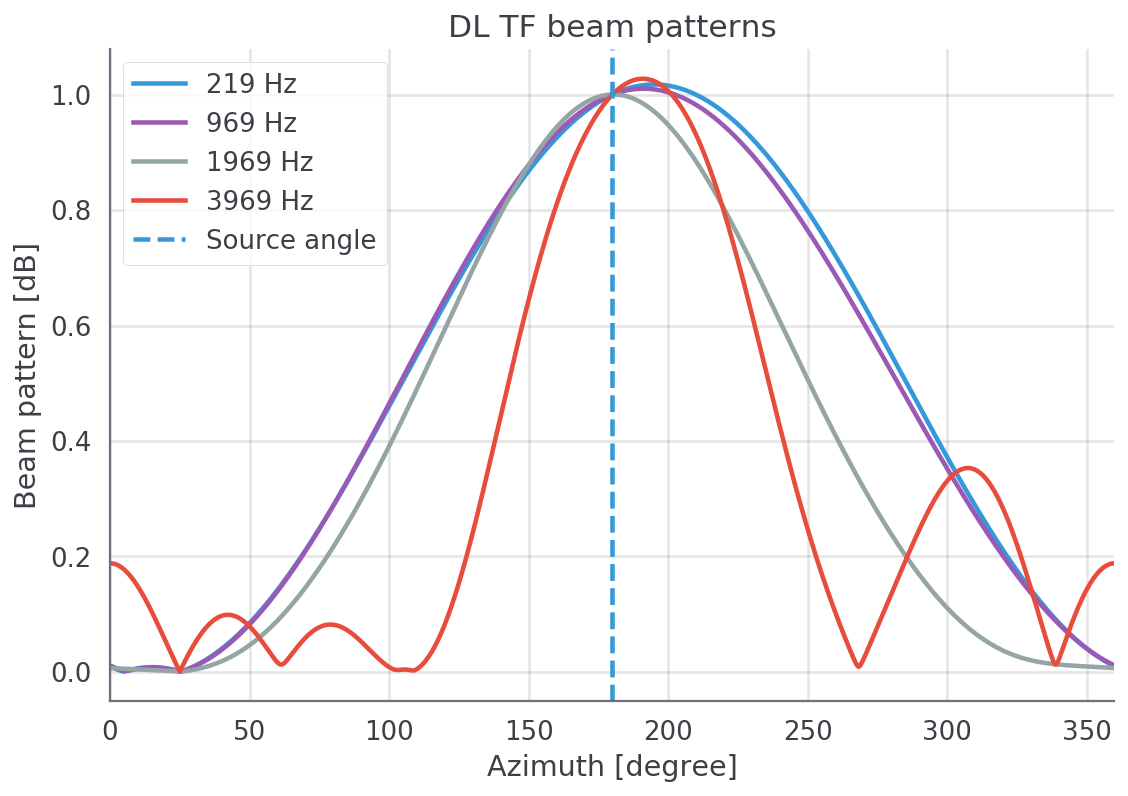

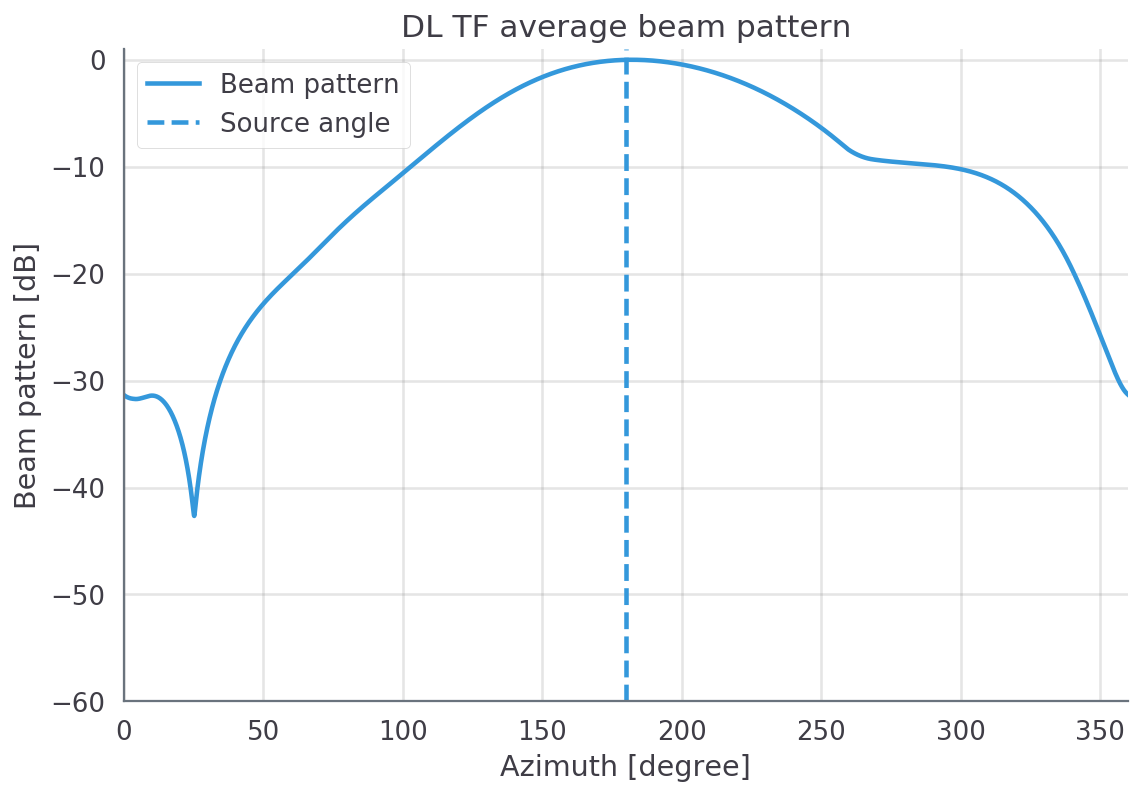

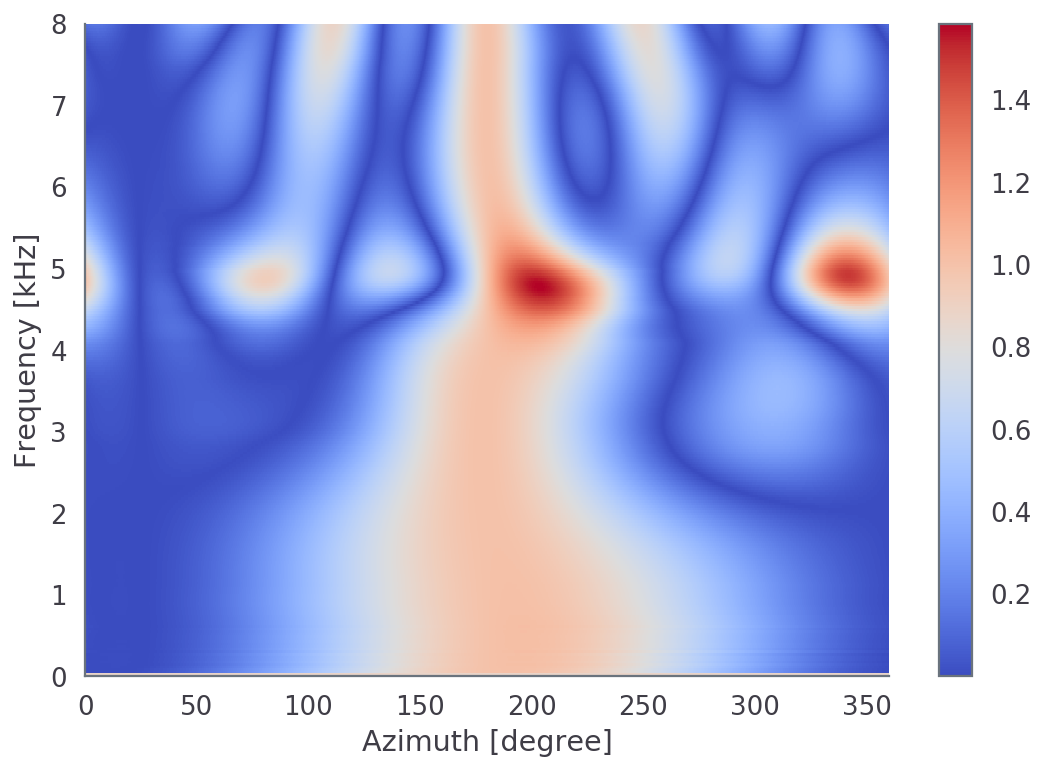

In [46]:
frequency_bins = [7, 31, 63, 127]
dl_beampattern = compute_tf_beampattern(beamformers["dlbeamformer"]["weights"], scanning_steering_vectors)
dl_beampattern_db = to_db(dl_beampattern)

visualize_beampattern_1d(np.abs(dl_beampattern[:, 0, :]), scanning_azimuth_grid, frequency_bins, 
    signal_max_frequency, source_azimuths= azimuth_s, title="DL TF beam patterns")

visualize_beampattern_1d_average(np.abs(dl_beampattern[:, 0, :]), scanning_azimuth_grid, 
    frequency_range=(0, 127), source_azimuths=azimuth_s, title="DL TF average beam pattern")

visualize_beampattern_2d(np.abs(dl_beampattern[:, 0, :]), 
    scanning_azimuth_grid, signal_max_frequency);

In [44]:
Audio(beamformers["dlbeamformer"]["out"], rate=sampling_frequency, autoplay=True)

In [45]:
interference

{'signal': array([    -5,    -13,    -15, ..., -12007, -10366,  -9322], dtype=int16),
 'elevation': array([-90]),
 'azimuth': array([21.6846394])}